# Capstone Project - The Battle of Neighborhoods | Setting up a coffee shop in Ho Chi Minh City

### 1. Installing and Import Python Libraries and Dependencies

Import necessary libraries

In [1]:
import pandas as pd
import numpy as np

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim
# tranform JSON file into a pandas dataframe
from pandas.io.json import json_normalize  

# Scrape the web to get the data
from bs4 import BeautifulSoup
import requests

# map rendering library
#!pip install folium 
import folium

# import k-means from clustering stage
from sklearn.cluster import KMeans

# find the distances
from scipy.spatial.distance import cdist

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# translate Vietnamese character (with accents) 
#     to the closest possible representation in ascii text
#!pip install unidecode
from unidecode import unidecode

     |████████████████████████████████| 102kB 9.1MB/s ta 0:00:011
     |████████████████████████████████| 245kB 10.5MB/s eta 0:00:01


### 2. Data extraction and Cleaning

In [2]:
source_wiki_hcm = requests.get("https://en.wikipedia.org/wiki/Ho_Chi_Minh_City").text
soup = BeautifulSoup(source_wiki_hcm, 'lxml')
table_wiki_hcm = ( soup.find("span", {"id": "Demographics"})
                    .parent.previous_sibling.previous_sibling )

table_rows = table_wiki_hcm.tbody.find_all("tr")
res_hcm = []
for tr in table_rows:
    td = tr.find_all("td")
    row = [tr.text for tr in td]
    res_hcm.append(row)

In [3]:
df_hcm = pd.DataFrame(res_hcm, columns=["District", "Subdistrict", 
                        "Area (km2)", "", "", "", "", "Population 2015", ""])
df_hcm.drop("", axis=1, inplace=True)
df_hcm = df_hcm.iloc[3:22].reset_index().drop("index", axis=1)
df_hcm["Population 2015"] = (
                            df_hcm["Population 2015"].str.replace("\n", "")
                                .str.replace(",", "")
                                .str.replace(".", "")
                                .str.strip()
                            )
# Add the "Density" column = Population / Area
df_hcm["Density (pop/m2)"] = round(df_hcm["Population 2015"].astype(float) 
                                       / df_hcm["Area (km2)"].astype(float)
                                   , 3)
# remove the word "District"
df_hcm["District"] = ( df_hcm["District"]
                              .str.replace("District", "")
                              .str.strip()
                         )
# remove Vietnamese accents
df_hcm["District"] = df_hcm["District"].apply(unidecode)
df_hcm

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2)
0,1,10 wards,7.73,193632,25049.418
1,2,11 wards,49.74,147168,2958.745
2,3,14 wards,4.92,196333,39905.081
3,4,15 wards,4.18,186727,44671.531
4,5,15 wards,4.27,178615,41830.211
5,6,14 wards,7.19,258945,36014.604
6,7,10 wards,35.69,310178,8690.894
7,8,16 wards,19.18,431969,22521.846
8,9,13 wards,114,290620,2549.298
9,10,15 wards,5.72,238558,41705.944


In [4]:
#Housing Price
source_housing_price = requests.get("https://mogi.vn/gia-nha-dat").text
soup = BeautifulSoup(source_housing_price, 'lxml')
table_housing_price = soup.find("div", class_="mt-table")

In [5]:
table_rows = table_housing_price.find_all("div", class_="mt-row")
res_housing_price = []
for tr in table_rows:
    district = tr.find("div", class_="mt-street").a.text
    medium_price = tr.find("div", class_="mt-vol").span.text
    row = [district, medium_price]
    res_housing_price.append(row)

In [6]:
df_housing_price = pd.DataFrame(res_housing_price, 
                                columns=["District", "Average Housing Price (1M VND/m2)"])
df_housing_price = df_housing_price.iloc[:19].reset_index().drop("index", axis=1)

# Remove the word "Quận"
df_housing_price["District"] = ( df_housing_price["District"]
                                        .str.replace("\n", "").str.replace("Quận", "")
                                        .str.strip() 
                                   )

# Remove Vietnamese accents
df_housing_price["District"] = df_housing_price["District"].apply(unidecode)

# Remove the word "triệu" (It's 10^6 in Vietnamese)
df_housing_price["Average Housing Price (1M VND/m2)"] = ( df_housing_price["Average Housing Price (1M VND/m2)"]
                                                          .str.replace("triệu/m2", "")
                                                          .str.replace(",", ".")
                                                          .str.strip()
                                                        )
df_housing_price

,District,Average Housing Price (1M VND/m2)
0,1,418
1,2,81.4
2,3,265
3,4,109
4,5,254
5,6,114
6,7,90.6
7,8,70.9
8,9,48.8
9,10,211


In [7]:
df = pd.merge(df_hcm, df_housing_price, how='left', left_on = 'District', right_on = 'District')
df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND/m2)
0,1,10 wards,7.73,193632,25049.418,418
1,2,11 wards,49.74,147168,2958.745,81.4
2,3,14 wards,4.92,196333,39905.081,265
3,4,15 wards,4.18,186727,44671.531,109
4,5,15 wards,4.27,178615,41830.211,254
5,6,14 wards,7.19,258945,36014.604,114
6,7,10 wards,35.69,310178,8690.894,90.6
7,8,16 wards,19.18,431969,22521.846,70.9
8,9,13 wards,114,290620,2549.298,48.8
9,10,15 wards,5.72,238558,41705.944,211


In [8]:
def find_coor(name):
    address = name + ", Vietnam"
    geolocator = Nominatim(user_agent="hcmc")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return [latitude, longitude]

In [9]:
# For District 1 to 12 (numbers)
coords = [find_coor("District " + dist) for dist in df["District"].iloc[:12].tolist()]

# For the other districts (letters)
coords = coords + [find_coor(dist + " District, Ho Chi Minh City") for dist in df["District"].iloc[12:].tolist()]

df_coords = pd.DataFrame(coords, columns=["Latitude", "Longitude"])

df["Latitude"] = df_coords["Latitude"]
df["Longitude"] = df_coords["Longitude"]

df

,District,Subdistrict,Area (km2),Population 2015,Density (pop/m2),Average Housing Price (1M VND/m2),Latitude,Longitude
0,1,10 wards,7.73,193632,25049.418,418,10.774540,106.699184
1,2,11 wards,49.74,147168,2958.745,81.4,10.791116,106.736729
2,3,14 wards,4.92,196333,39905.081,265,10.783529,106.687098
3,4,15 wards,4.18,186727,44671.531,109,10.759243,106.704890
4,5,15 wards,4.27,178615,41830.211,254,10.756129,106.670376
5,6,14 wards,7.19,258945,36014.604,114,10.746928,106.634495
6,7,10 wards,35.69,310178,8690.894,90.6,10.736573,106.722432
7,8,16 wards,19.18,431969,22521.846,70.9,10.740400,106.665843
8,9,13 wards,114,290620,2549.298,48.8,10.824543,106.818015
9,10,15 wards,5.72,238558,41705.944,211,10.773198,106.667833


### Plotting map

In [10]:
[hcm_lat, hcm_long] = find_coor('Ho Chi Minh City')
print('The geograpical coordinate of Ho Chi Minh City are {}, {}.'.format(hcm_lat, hcm_long))

The geograpical coordinate of Ho Chi Minh City are 10.7758439, 106.7017555.


In [11]:
map_hcm = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)
for lat, lng, dis in zip(df['Latitude'], df['Longitude'], df['District']):
    label = '{}'.format(dis)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  

map_hcm

### Define Foursquare Credentials and Version

In [12]:
CLIENT_ID = 'HGGSGGOUTABD3QLWGUGI3B0TZAJBIRTDWOVJMTDRAHYN4XPG'
CLIENT_SECRET = '40KBHN400DS11Q3CK5K3N4RDOWBPEO544SGO1PBSCHC40121'
VERSION = '20180605'

### Explore the Venues of urban districts

In [13]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500, LIMIT=150):
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        # print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [14]:
hcm_venues = getNearbyVenues(names=df['District'],
                             latitudes=df['Latitude'],
                             longitudes=df['Longitude']
                            )

In [15]:
hcm_venues.head()

,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,1,10.77454,106.699184,Pizza 4P's,10.773301,106.697599,Pizza Place
1,1,10.77454,106.699184,Liberty Central Saigon Citypoint Hotel,10.774758,106.700795,Hotel
2,1,10.77454,106.699184,Pasteur Street Brewing Company,10.775220,106.700894,Brewery
3,1,10.77454,106.699184,Quán Lộc Thành,10.772472,106.698441,Vietnamese Restaurant
4,1,10.77454,106.699184,Takashimaya,10.773194,106.701075,Department Store


In [16]:
hcm_venues_group = hcm_venues[['District','Venue']].groupby('District').count().reset_index()
hcm_venues_group

,District,Venue
0,1,100
1,10,100
2,11,41
3,12,4
4,2,56
5,3,100
6,4,70
7,5,100
8,6,14
9,7,62


In [17]:
print('In above table, there are {} uniques categories.'.format(len(hcm_venues['Venue Category'].unique())))

In above table, there are 137 uniques categories.


### Results

#### The list of unique categories

In [18]:
hcm_venues['Venue Category'].unique()

array(['Pizza Place', 'Hotel', 'Brewery', 'Vietnamese Restaurant',
       'Department Store', 'Multiplex', 'Supermarket', 'Jazz Club',
       'Spanish Restaurant', 'Café', 'Speakeasy', 'Steakhouse',
       'Massage Studio', 'Dessert Shop', 'Coffee Shop', 'Whisky Bar',
       'Italian Restaurant', 'Clothing Store', 'Bar', 'Restaurant',
       'Asian Restaurant', 'Spa', 'German Restaurant', 'Tapas Restaurant',
       'Burger Joint', 'Jewelry Store', 'Opera House', 'Bookstore',
       'Noodle House', 'Mexican Restaurant', 'Nightclub',
       'Vegetarian / Vegan Restaurant', 'Cocktail Bar', 'Cupcake Shop',
       'Museum', 'Thai Restaurant', 'French Restaurant',
       'Middle Eastern Restaurant', 'North Indian Restaurant',
       'Hawaiian Restaurant', 'Argentinian Restaurant', 'Hotel Bar',
       'Indian Restaurant', 'Hotpot Restaurant', 'Video Game Store',
       'Food Court', 'Korean Restaurant', 'Shoe Store', 'Sandwich Place',
       'Park', 'BBQ Joint', 'Breakfast Spot', 'Beer Bar', 

#### Number of venues in each district

Text(0.5, 0, '')

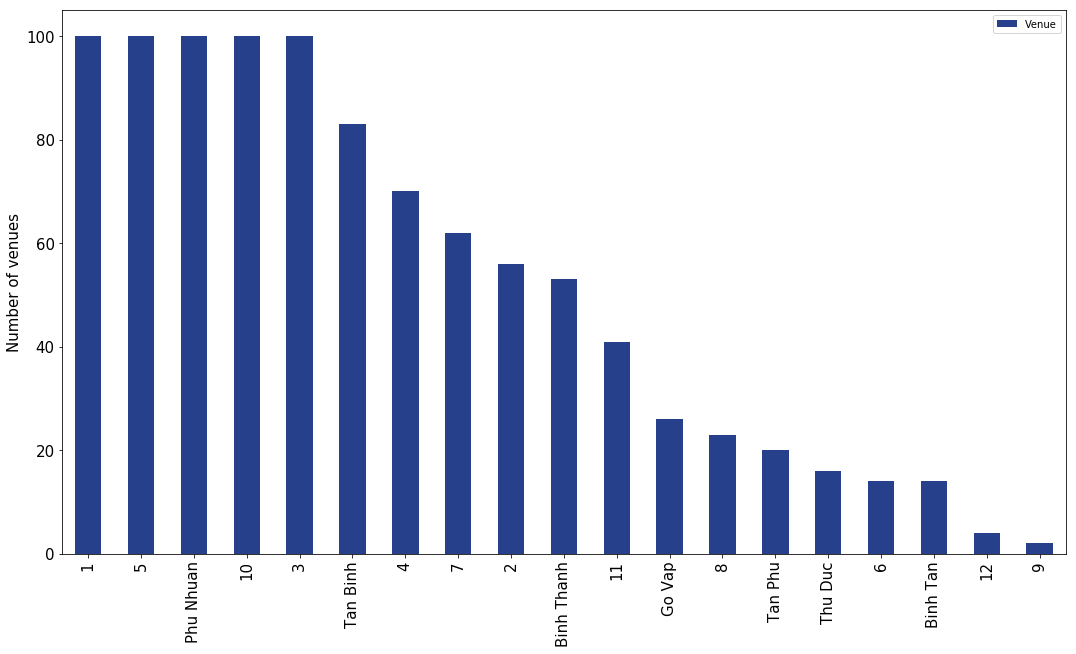

In [32]:
ax = hcm_venues_group.sort_values(by="Venue", ascending=False).plot(x="District", y="Venue", kind="bar", figsize=(18,10), color='#27408B')
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel("Number of venues", fontsize=15)
ax.set_xlabel('')

#### Number of venues in each category

In [34]:
most_venues = hcm_venues[['Venue Category','Venue']].groupby('Venue Category').count().sort_values(by="Venue", ascending=False)
most_venues.head(5)

,Venue
Venue Category,
Vietnamese Restaurant,137
Café,129
Coffee Shop,73
Seafood Restaurant,40
Hotel,30


In [35]:
129 + 73

202

#### The number of categories in each district

Text(0.5, 0, '')

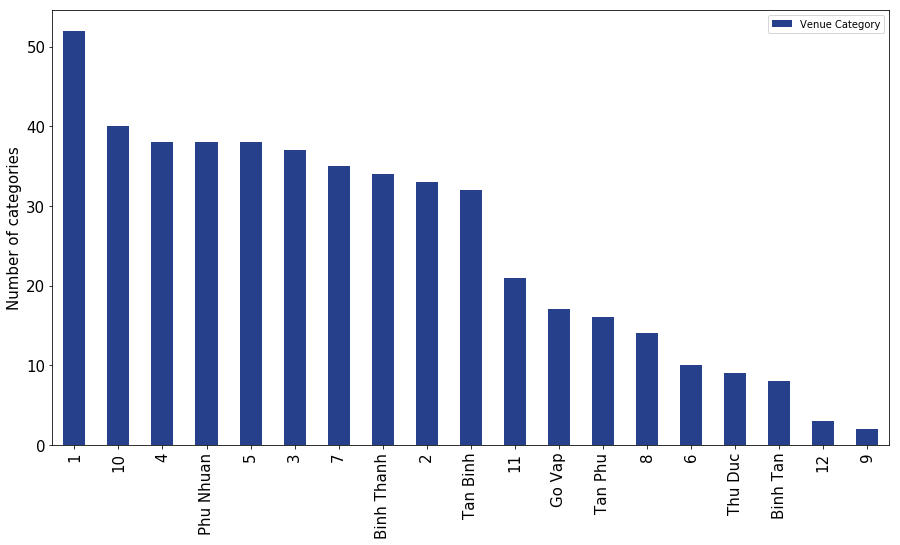

In [38]:
hcm_venues_group_cat = (
    hcm_venues.groupby(['District','Venue Category'])
        .count().reset_index()[['District', 'Venue Category']]
            .groupby('District').count().reset_index()
)
# hcm_venues_group_cat
ax = hcm_venues_group_cat.sort_values(by="Venue Category", ascending=False).plot(x="District", y="Venue Category", kind="bar", figsize=(15,8), color='#27408B')
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_ylabel("Number of categories", fontsize=15)
ax.set_xlabel('')

#### Top 10 venue categories for each district

In [39]:
# one hot encoding
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add district column back to dataframe
hcm_onehot['District'] = hcm_venues['District'] 

# move district column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]

# group the rows by district and by taking the mean of the frequency of occurrence of each category
hcm_grouped = hcm_onehot.groupby('District').mean().reset_index()
hcm_grouped.head()

,District,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,Badminton Court,Bagel Shop,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wings Joint,Yoga Studio
0,1,0.0,0.01,0.0,0.00,0.01000,0.0,0.010000,0.0,0.0,...,0.000000,0.03000,0.0,0.01,0.100000,0.0,0.00000,0.01,0.000000,0.0
1,10,0.0,0.00,0.0,0.01,0.02000,0.0,0.010000,0.0,0.0,...,0.000000,0.03000,0.0,0.00,0.190000,0.0,0.00000,0.00,0.000000,0.0
2,11,0.0,0.00,0.0,0.00,0.02439,0.0,0.000000,0.0,0.0,...,0.000000,0.02439,0.0,0.00,0.097561,0.0,0.02439,0.00,0.000000,0.0
3,12,0.0,0.00,0.0,0.00,0.00000,0.0,0.000000,0.0,0.0,...,0.000000,0.00000,0.0,0.00,0.250000,0.0,0.00000,0.00,0.000000,0.0
4,2,0.0,0.00,0.0,0.00,0.00000,0.0,0.071429,0.0,0.0,...,0.017857,0.00000,0.0,0.00,0.125000,0.0,0.00000,0.00,0.017857,0.0


In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['District']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hcm_10 = pd.DataFrame(columns=columns)
hcm_10['District'] = hcm_grouped['District']

for ind in np.arange(hcm_grouped.shape[0]):
    hcm_10.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)

hcm_10

,District,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Hotel,Vietnamese Restaurant,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Pizza Place,Hotel Bar,Massage Studio,Brewery,Hotpot Restaurant
1,10,Vietnamese Restaurant,Café,Coffee Shop,Dessert Shop,Hotpot Restaurant,Vegetarian / Vegan Restaurant,Seafood Restaurant,Spa,Hotel,Market
2,11,Café,Chinese Restaurant,Seafood Restaurant,Vietnamese Restaurant,Cantonese Restaurant,Fast Food Restaurant,Mobile Phone Shop,Theme Park,Dessert Shop,Shopping Mall
3,12,Café,Department Store,Vietnamese Restaurant,Film Studio,Food Truck,Food Court,Food,Flower Shop,Flea Market,Fast Food Restaurant
4,2,Vietnamese Restaurant,Restaurant,BBQ Joint,Café,Coffee Shop,Tea Room,Multiplex,Burger Joint,Bakery,Sandwich Place
5,3,Vietnamese Restaurant,Café,Coffee Shop,Vegetarian / Vegan Restaurant,Hotel,Asian Restaurant,Pizza Place,Noodle House,Spa,Breakfast Spot
6,4,Vietnamese Restaurant,Seafood Restaurant,Coffee Shop,Café,Snack Place,Food,Diner,Mexican Restaurant,Asian Restaurant,Hostel
7,5,Vietnamese Restaurant,Chinese Restaurant,Coffee Shop,Dim Sum Restaurant,Café,Dessert Shop,Noodle House,Asian Restaurant,Seafood Restaurant,BBQ Joint
8,6,Café,Supermarket,Dessert Shop,Fast Food Restaurant,Movie Theater,Breakfast Spot,Pizza Place,Bagel Shop,Vietnamese Restaurant,Department Store
9,7,Café,Vietnamese Restaurant,Coffee Shop,Seafood Restaurant,Gym / Fitness Center,Sushi Restaurant,Flea Market,Hotel,Multiplex,Pizza Place


### Data relating to category "Coffee shop" only

In [42]:
hcm_grouped_cafe = hcm_grouped[["District", "Coffee Shop"]]
hcm_grouped_cafe

,District,Coffee Shop
0,1,0.050000
1,10,0.110000
2,11,0.000000
3,12,0.000000
4,2,0.053571
5,3,0.080000
6,4,0.057143
7,5,0.060000
8,6,0.000000
9,7,0.064516


Determine which k should be used wuth elbow method

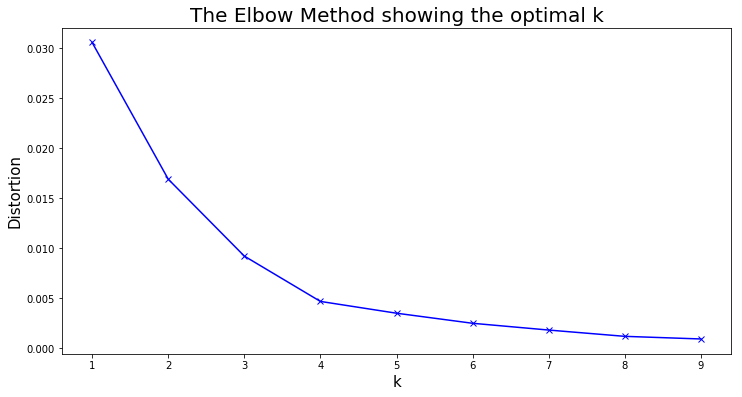

In [50]:
# try with 10 different values of k to find the best one
Ks = 10
distortions = []

hcm_cafe_clustering = hcm_grouped_cafe.drop('District', 1)

for k in range(1, Ks):

    # run k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(hcm_cafe_clustering)

    # find the distortion w.r.t each k
    distortions.append(
        sum(np.min(cdist(hcm_cafe_clustering, kmeans.cluster_centers_, 'euclidean'), axis=1))
        / hcm_cafe_clustering.shape[0]
    )

plt.figure(figsize=(12,6))
plt.plot(range(1, Ks), distortions, 'bx-')
plt.xlabel('k', fontsize=15)
plt.ylabel('Distortion', fontsize=15)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
plt.title('The Elbow Method showing the optimal k', fontsize=20)
plt.show()

Use the K-Means clustering wih best k as 3

In [51]:
nclusters = 4
kmeans = KMeans(n_clusters=nclusters, random_state=0).fit(hcm_cafe_clustering)

In [52]:
df_cafe = hcm_grouped_cafe.copy()
df_cafe["Cluster Labels"] = kmeans.labels_

# add two columns Latitude and Logitude into cafe_merged
df_cafe = df_cafe.join(df.set_index("District"), on="District")

# sort the table by cluster labels
df_cafe.sort_values(["Cluster Labels"], inplace=True)

# Drop some unnecessary columns
df_cafe = df_cafe.drop(["Subdistrict", "Area (km2)"], axis=1)

# change to numeric date type
df_cafe['Average Housing Price (1M VND/m2)'] = df_cafe['Average Housing Price (1M VND/m2)'].astype(float)
df_cafe

,District,Coffee Shop,Cluster Labels,Population 2015,Density (pop/m2),Average Housing Price (1M VND/m2),Latitude,Longitude
1,10,0.110000,0,238558,41705.944,211.0,10.773198,106.667833
15,Phu Nhuan,0.130000,0,182477,37392.828,182.0,10.800118,106.677042
12,Binh Tan,0.142857,0,686474,13229.408,60.0,10.749809,106.605664
16,Tan Binh,0.084337,1,459029,20510.679,145.0,10.797979,106.653805
5,3,0.080000,1,196333,39905.081,265.0,10.783529,106.687098
14,Go Vap,0.076923,1,634146,32124.924,96.3,10.840150,106.671083
13,Binh Thanh,0.075472,1,487985,23506.021,134.0,10.804659,106.707848
10,8,0.086957,1,431969,22521.846,70.9,10.740400,106.665843
2,11,0.000000,2,230596,44863.035,164.0,10.764208,106.643282
3,12,0.000000,2,510326,9668.928,46.5,10.867233,106.653930


### Visualize the clusters on map

In [56]:
map_clusters = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(nclusters)
ys = [i+x+(i*x)**2 for i in range(nclusters)]
colors_array = ['#FF3333','#CC00FF','#0000FF','#FFFF00']
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cafe['Latitude'], 
        df_cafe['Longitude'], 
        df_cafe['District'], 
        df_cafe['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine the range of Average Housing Price (AHP)

Range of AHP
1. Low : 30 &lt; AHP $\le$ 100.
2. Medium : 100 &lt; AHP $\le$ 200.
3. High : 200 &lt; AHP $\le$ 300.
4. Very High : 300 &lt; AHP.

In [57]:
count, division = np.histogram(df_cafe['Average Housing Price (1M VND/m2)'], bins = [30, 100, 200, 300, 400])

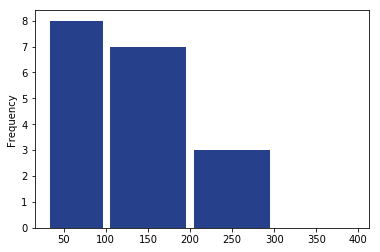

In [59]:
df_cafe['Average Housing Price (1M VND/m2)'].plot.hist(bins=division, rwidth=0.9, color='#27408B')

In [60]:
#Number of districts in each range of AHP
count

array([8, 7, 3, 0])

Now, we want to classify the AHP of each district into above types by creating a new columns whose name is "AHP Level". In order to do that, we need to create a function first.

In [61]:
def classify_ahp(price):
    if price <= 100:
        return "Low"
    elif price <= 200:
        return "Medium"
    elif price <= 300:
        return "High"
    else:
        return "Very High"

In [62]:
df_cafe["AHP Level"] = df_cafe["Average Housing Price (1M VND/m2)"].apply(classify_ahp)
df_cafe

,District,Coffee Shop,Cluster Labels,Population 2015,Density (pop/m2),Average Housing Price (1M VND/m2),Latitude,Longitude,AHP Level
1,10,0.110000,0,238558,41705.944,211.0,10.773198,106.667833,High
15,Phu Nhuan,0.130000,0,182477,37392.828,182.0,10.800118,106.677042,Medium
12,Binh Tan,0.142857,0,686474,13229.408,60.0,10.749809,106.605664,Low
16,Tan Binh,0.084337,1,459029,20510.679,145.0,10.797979,106.653805,Medium
5,3,0.080000,1,196333,39905.081,265.0,10.783529,106.687098,High
14,Go Vap,0.076923,1,634146,32124.924,96.3,10.840150,106.671083,Low
13,Binh Thanh,0.075472,1,487985,23506.021,134.0,10.804659,106.707848,Medium
10,8,0.086957,1,431969,22521.846,70.9,10.740400,106.665843,Low
2,11,0.000000,2,230596,44863.035,164.0,10.764208,106.643282,Medium
3,12,0.000000,2,510326,9668.928,46.5,10.867233,106.653930,Low


**We can understand the clusters**

* Cluster 0: There are a lot of coffee shops in these districts.
* Cluster 1: The number of coffee shops in these districts is medium..
* Cluster 2: There are no coffee shops in these districts
* Cluster 3: There are a few coffee shops in these districts

### Choropleth map of AHP

Now we want to create a choropleth map of AHP coupling with the map of clusters created in previous section.

In [63]:
# The code was removed by Watson Studio for sharing.

In [64]:
map_ahp = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

map_ahp.choropleth(
 geo_data=hcm_geo,
 name='choropleth',
 data=df_cafe,
 columns=['District', 'Average Housing Price (1M VND/m2)'],
 key_on='feature.properties.name',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Average Housing Price'
)
# folium.LayerControl().add_to(map_ahp)

# add clusters to the map
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cafe['Latitude'], 
        df_cafe['Longitude'], 
        df_cafe['District'], 
        df_cafe['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_ahp)

map_ahp

/opt/conda/envs/Python36/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


In [65]:
map_density = folium.Map(location=[hcm_lat, hcm_long], zoom_start=11)

map_density.choropleth(
 geo_data=hcm_geo,
 name='choropleth',
 data=df_cafe,
 columns=['District', 'Density (pop/m2)'],
 key_on='feature.properties.name',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Population density'
)
# folium.LayerControl().add_to(map_ahp)

# add clusters to the map
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(
        df_cafe['Latitude'], 
        df_cafe['Longitude'], 
        df_cafe['District'], 
        df_cafe['Cluster Labels']
):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_density)

map_density

# Conclusion

From all above results, we conclude that, the best place for us to set up a new coffee shop is in Tan Phu district because there are a lot of people living there (high density as 28,922.35 pop/m2), there are not many already-working coffee shop (cluster 3) and the average housing price is low (as 102 million VND/m2).